# Setup

In [1]:
%%capture
!pip show transformers
!pip show accelerate
!pip install transformers[torch] -U
!pip install accelerate -U
!pip install transformers
!pip install pytorch-lightning
!pip install --upgrade transformers
!pip install datasets

# Preprocessing

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification


# 1. Prepare Dataset
# 2. Load pretrained Tokenizer, call it with dataset -> encoding
# 3. Build PyTorth Dataset with encodings
# 4. Load pretrained Model
# 5. Load HF Trainer and train it


# Train Data - 52662 rows after pre-processing (done above)
toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_train_df = toxicity_train_df.dropna()


# Test Data - 7287 rows after pre-processing
toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
toxicity_test_df = toxicity_test_df.dropna()


# Sampling for CPU use
# fraction = 0.1

# toxicity_train_df = toxicity_train_df.sample(frac=fraction, random_state=42)
# toxicity_test_df = toxicity_test_df.sample(frac=fraction, random_state=42)

# # Reset index for consistency
# toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# List of categories to check
categories_to_check = ['obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']

# Check if any category is above the 0.5 threshold
toxicity_train_df[categories_to_check] = toxicity_train_df[categories_to_check].apply(pd.to_numeric, errors='coerce')
toxicity_test_df[categories_to_check] = toxicity_test_df[categories_to_check].apply(pd.to_numeric, errors='coerce')

# Check if any category is above the 0.5 threshold
toxicity_train_df['toxic'] = (toxicity_train_df[categories_to_check] >= 0.5).any(axis=1).astype(float)
toxicity_test_df['toxic'] = (toxicity_test_df[categories_to_check] >= 0.5).any(axis=1).astype(float)

# Convert boolean values to 1.0 for True and 0.0 for False
toxicity_train_df['toxic'] = toxicity_train_df['toxic'].astype(float)
toxicity_test_df['toxic'] = toxicity_test_df['toxic'].astype(float)

toxicity_train_df = toxicity_train_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]
toxicity_test_df = toxicity_test_df[['comment_text', 'toxic', 'obscene', 'sexual_explicit', 'threat', 'insult', 'identity_attack']]


# Fraction of the majority class you want to keep (e.g., 0.2 for 20%)
undersample_fraction = 0.33

# Separate the majority and minority classes in training data
majority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 0]
minority_class_train = toxicity_train_df[toxicity_train_df['toxic'] == 1]

# Undersample the majority class in training data
undersampled_majority_class_train = majority_class_train.sample(frac=undersample_fraction, random_state=42)

# Concatenate the undersampled majority class with the minority class in training data
undersampled_train_df = pd.concat([undersampled_majority_class_train, minority_class_train])

# Shuffle the undersampled training dataframe
toxicity_train_df = undersampled_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate the majority and minority classes in test data
majority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 0]
minority_class_test = toxicity_test_df[toxicity_test_df['toxic'] == 1]

# Display the class distribution before and after undersampling
print("\nClass distribution in training data after undersampling:")
print(toxicity_train_df['toxic'].value_counts())

print("\nClass distribution in test data before undersampling:")
print(toxicity_test_df['toxic'].value_counts())

<ipython-input-2-82526e0c1a93>:21: DtypeWarning: Columns (13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,39,40,41,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_train_df = pd.read_csv('toxicity_train.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)
<ipython-input-2-82526e0c1a93>:26: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  toxicity_test_df = pd.read_csv('toxicity_test.csv', on_bad_lines='skip', quoting=csv.QUOTE_NONE)



Class distribution in training data after undersampling:
0.0    12144
1.0     9285
Name: toxic, dtype: int64

Class distribution in test data before undersampling:
0.0    6248
1.0    1039
Name: toxic, dtype: int64


Test Lengths of DFs

In [3]:
print(len(toxicity_train_df))
print(len(toxicity_test_df))

21429
7287


# Visualization of toxicity in train

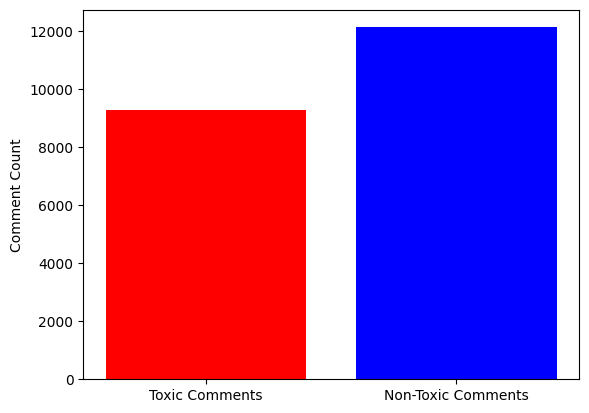

In [4]:
# Count toxic and non-toxic comments
toxic_count = toxicity_train_df['toxic'].sum()
non_toxic_count = len(toxicity_train_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Visualization of toxicity in test

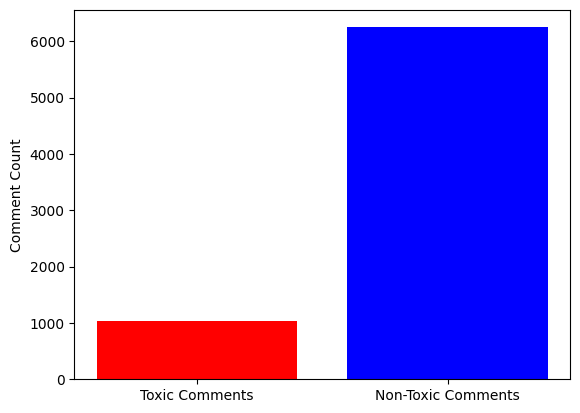

In [5]:
# Count toxic and non-toxic comments
toxic_count = toxicity_test_df['toxic'].sum()
non_toxic_count = len(toxicity_test_df) - toxic_count

# Plot side-by-side bars for toxic and non-toxic comments
labels = ['Toxic Comments', 'Non-Toxic Comments']
counts = [toxic_count, non_toxic_count]

plt.bar(labels, counts, color=['red', 'blue'])
plt.ylabel('Comment Count')

plt.show()

# Splitting and Labelling

In [6]:
# model_name = "roberta-base"

# toxicity_train_df.reset_index(drop=True, inplace=True)
# toxicity_test_df.reset_index(drop=True, inplace=True)

# X_train = toxicity_train_df[['comment_text']].reset_index(drop=True)
# X_train = X_train.dropna()

# # y_train = toxicity_train_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
# y_train = toxicity_train_df[['toxic']].reset_index(drop=True)
# y_train = y_train.dropna()
# # toxicity_train_df.info()


# # toxicity_test_df.info()
# X_test = toxicity_test_df[['comment_text']].reset_index(drop=True)
# X_test = X_test.dropna()
# # # y_test = toxicity_test_df[['obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']]
# y_test = toxicity_test_df[['toxic']].reset_index(drop=True)
# y_test = y_test.dropna()


# train_texts = X_train['comment_text'].tolist()
# train_labels = y_train
# test_texts = X_test['comment_text'].tolist()
# test_labels = y_test

# # See examples of texts & labels
# print("train_texts:")
# print(train_texts[:5])
# print("train_labels:")
# print(train_labels[:5])
# print("test_texts")
# print(test_texts[:5])
# print("test_labels:")
# print(test_labels[:5])

# train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

model_name = "roberta-base"

# Reset index to ensure consistency
toxicity_train_df.reset_index(drop=True, inplace=True)
toxicity_test_df.reset_index(drop=True, inplace=True)

# Select relevant columns from DataFrame and drop NaN values
train_data = toxicity_train_df[['comment_text', 'toxic']].dropna()
test_data = toxicity_test_df[['comment_text', 'toxic']].dropna()

# Extract features and labels
train_texts = train_data['comment_text'].tolist()
train_labels = train_data['toxic'].tolist()
test_texts = test_data['comment_text'].tolist()
test_labels = test_data['toxic'].tolist()

# Print examples of texts & labels
print("train_texts:")
print(train_texts[:5])
print("train_labels:")
print(train_labels[:5])
print("test_texts")
print(test_texts[:5])
print("test_labels:")
print(test_labels[:5])

# Split train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2)


train_texts:
[' missing and mostly party line pious prattle and uninspiring. We are losing nearly all of our youth and young families. We are closing parishes merely for lack of priests. We have mostly foreign born priests from non-English speaking countries filling in the gaps and leaving congregations confused', '"" but he was old enough to know that killing other people is something you can never take back. The purpose of him being in jail is that we like to think of ourselves as a civilized society that would not put him to death. Is it kinder to incarcerate someone for the rest of their lives than to execute them? Perhaps not. But I don\'t see him ever being able to redeem himself enough to be released into society."', " rather than drag her into public and make political hay on her tragedy. Don't you see that? Trump used her for a political score. Trump approved the FUBAR raid over dinner. One month into office and Trump has his Benghazi. But will Jason Chaffetz", ' all the dicta

# Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel


class ToxicDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).float()
        return item

    def __len__(self):
        return len(self.labels)

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

train_dataset = ToxicDataset(train_encodings, train_labels)
val_dataset = ToxicDataset(val_encodings, val_labels)
test_dataset = ToxicDataset(test_encodings, test_labels)

print("Train Dataset")
# Iterate over train_dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Val Dataset")
# Iterate over val dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = val_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

print("Test Dataset")
# Iterate over test dataset and print some samples
for i in range(3):  # Print first 3 samples
    sample = test_dataset[i]
    print(f"Sample {i + 1}:")
    # Convert input_ids tensor to list and access its keys
    encoding_keys = tokenizer.convert_ids_to_tokens(sample["input_ids"].tolist())
    print("Encoding keys:", encoding_keys)  # Print keys of encoding
    print("Label:", sample["labels"].item())  # Print label
    print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Train Dataset
Sample 1:
Encoding keys: ['<s>', 'ĠI', 'Ġthink', 'Ġit', "'s", 'Ġthe', 'Ġpart', 'Ġwhere', 'ĠJesus', 'Ġsays', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

# Tokenizer + Encodings + Training

In [8]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.squeeze()

    # Apply sigmoid activation function to convert logits to probabilities
    preds = 1 / (1 + np.exp(-preds))

    # Round probabilities to get binary predictions
    binary_preds = np.round(preds)

    # Calculate accuracy
    accuracy = accuracy_score(labels, binary_preds)

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, binary_preds, average='binary')

    # Calculate AUC-ROC
    auc_roc = roc_auc_score(labels, preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

# Define the model with BCE loss
model = AutoModelForSequenceClassification.from_pretrained('roberta-base', num_labels=1)

# Define the BCE loss function
loss_function = "bce_with_logits"  # Binary Cross-Entropy Loss

# Define the training arguments (GPU Version)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=200,
    learning_rate=1e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1230,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=1230,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)


# Create the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


model.save_pretrained('/results/fine_tuned_roberta_model')

# text = "Replace me by any text you'd like."
# encoded_input = tokenizer(text, return_tensors='pt')
# output = model(**encoded_input)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Auc Roc
1230,0.245500,0.212139,0.433504,0.433504,1.000000,0.604818,0.709704


# Evaluation

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Use the trained model for evaluation
eval_results = trainer.evaluate()

# Print evaluation results
print(eval_results)

# Make predictions on the validation set
predictions = trainer.predict(val_dataset)

# Convert predictions to probabilities and get class labels
predicted_probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)
predicted_labels = torch.argmax(predicted_probabilities, dim=1)

# Flatten the true labels
true_labels = np.array(val_labels)

# Calculate accuracy and print classification report
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")
print(classification_report(true_labels, predicted_labels))

# Count occurrences of each class in true labels
true_label_counts = np.bincount(true_labels.astype(int))

# Count occurrences of each class in predicted labels
predicted_label_counts = np.bincount(predicted_labels.numpy().astype(int))

# Print the counts
print("True Label Counts (Class 0 and 1):", true_label_counts)
print("Predicted Label Counts (Class 0 and 1):", predicted_label_counts)


{'eval_loss': 0.2121390551328659, 'eval_accuracy': 0.43350443303779745, 'eval_precision': 0.43350443303779745, 'eval_recall': 1.0, 'eval_f1': 0.6048177083333333, 'eval_auc_roc': 0.7097036192394791, 'eval_runtime': 39.3416, 'eval_samples_per_second': 108.943, 'eval_steps_per_second': 1.703, 'epoch': 2.0}
Accuracy: 0.5664955669622025
              precision    recall  f1-score   support

         0.0       0.57      1.00      0.72      2428
         1.0       0.00      0.00      0.00      1858

    accuracy                           0.57      4286
   macro avg       0.28      0.50      0.36      4286
weighted avg       0.32      0.57      0.41      4286

True Label Counts (Class 0 and 1): [2428 1858]
Predicted Label Counts (Class 0 and 1): [4286]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions on Twitch Dataset

In [11]:
import pandas as pd
from transformers import RobertaTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Load the fine-tuned model for inference
tokenizer = RobertaTokenizer.from_pretrained('/content/results/checkpoint-1230/')
model = AutoModelForSequenceClassification.from_pretrained('/content/results/checkpoint-1230/')

twitch_df = pd.read_csv('twitch_toxicity.csv')
print(twitch_df.head(6))
print(twitch_df.info())

# Create a text classification pipeline
classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

# Example function to apply the classifier to each row in the DataFrame
# count = 0

# Function to convert LABEL_0 to 'no'
def convert_label(prediction):
    return 'no' if prediction[0]['label'] == 'LABEL_0' else 'yes'

# Example function to apply the classifier to each row in the DataFrame
def predict_label(row):
    text_to_predict = row['comment_text']
    prediction = classifier(text_to_predict)
    return convert_label(prediction)

# Apply the prediction function to each row in the DataFrame
twitch_df['roberta_prediction'] = twitch_df.head(300).apply(predict_label, axis=1)
# twitch_df['roberta_prediction'] = twitch_df.apply(predict_label, axis=1)

# Display the DataFrame with predictions
print(twitch_df.head(300)[['comment_text', 'roberta_prediction', 'toxic']])

# Assuming 'LABEL_0' corresponds to 'no'
prediction_counts = twitch_df.head(300)['roberta_prediction'].value_counts()

# Print the counts
print("Count of 'no':", prediction_counts.get('no', 0))
print("Count of 'yes':", prediction_counts.get('yes', 0))  # Adjust the label if needed


           user                                       comment_text toxic
0    firstdjinn  Confused why people are spamming things like J...    no
1        zCrean       Nice thats my first time in Hasan Lifestream    no
2     AfroTohru     THE ONE PIECE IS REAL LETSGO NEWS TODAY LETSGO    no
3  Julian4Mayor  Dont forget to check ur cocks before stream st...    no
4   RogueStereo  THE HASANABI IS REAL LETSGO THE HASANABI IS RE...    no
5   eddyeduardo        hey guys I'm finally here early, I love you    no
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11449 entries, 0 to 11448
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user          11449 non-null  object
 1   comment_text  11449 non-null  object
 2   toxic         11449 non-null  object
dtypes: object(3)
memory usage: 268.5+ KB
None
                                          comment_text roberta_prediction  \
0    Confused why people are spamming things li